# Basic engine implementation

#### setup

In [9]:
import face_recognition, PIL.Image, PIL.ImageDraw,math
import numpy as np
import logging
import cv2
import platform
from matplotlib import pyplot as plt
from PIL import Image
import scipy.signal as sig

FORMAT = '[%(asctime)s] [%(levelname)s] [%(funcName)s] [%(lineno)d] : %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

logging.info("Starting ...")
if platform.system() == "Windows":
    seperator = "\\"
else:
    seperator = "/"

dir = "perry-all-2"
# should be a parameter of the engine
dataset_location = ".." + seperator + "dataset" + seperator + "good_sync" + seperator
specific_dir = dir
video_location = dataset_location + specific_dir + seperator + "test1.mp4"

[2021-04-24 17:48:35,336] [INFO] [<module>] [13] : Starting ...


## running evm pre-processing

In [ ]:
%run ./evm_preprocessing.ipynb
# video_location = dataset_location + specific_dir + seperator + "out.avi"
video_location="out2.avi"

#### Detecting the face landmarks and parsing the ROI

In [2]:
def parse_roi(frame):
    # image = face_recognition.load_image_file(frame) # read image.
    face_locations = face_recognition.face_locations(frame,model = 'hog') # detects all the faces in image
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    # iterate through all the faces.
    for face_location in face_locations:
        img = PIL.Image.fromarray(frame)
        top,right,bottom,left = face_location # extract all face square points.
        diff = math.floor((top - bottom) * 0.15) # 20 percent of the face len (toadd eyebrow top point).
        
        # finding the forehead
        try:
            right_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['right_eyebrow']) # right eyebrow points.
        except:
            return None
        right_eyebrow_landmarks.sort(axis=0)
        rightest_point = right_eyebrow_landmarks[-1] # The most right point of the ROI(according to x).
        top_right_eyebrow = right_eyebrow_landmarks.min(axis = 0)[1]
        try:
            left_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['left_eyebrow'])
        except:
            return None
        left_eyebrow_landmarks.sort(axis=0)
        leftest_point = left_eyebrow_landmarks[0] # the most left point of ROI.(according to x)
        top_left_eyebrow = left_eyebrow_landmarks.min(axis = 0)[1]
        bottom = min(top_right_eyebrow,top_left_eyebrow).item(0) # bottom point of the forehead.
        bottom = bottom - (0.05 * bottom) # improve bottom location by 2 percent.
        forehead = img.crop((leftest_point[0], leftest_point[1]+diff, rightest_point[0],bottom+10)) # adding diff to top to make the forehead bigger.

        # finding the second ROI:
        try:
            upper_mouth = np.asarray(face_landmarks_list[0]['top_lip']) # top_lip landmarks
        except:
            return None
        upper_mouth_min = upper_mouth.min(axis = 0)[1] # The  top - lip upper point.
        try:
            upper_nose = np.asarray(face_landmarks_list[0]['nose_bridge'])
        except:
            return None
        upper_nose_min = upper_nose.min(axis = 0)[1]  # noise bridge upper point.
        upper_nose_min += upper_mouth_min * 0.1 # improving the noise bridge upper point.
        nose_to_upper_lip = img.crop((leftest_point[0], upper_nose_min, rightest_point[0], upper_mouth_min))

        return forehead, nose_to_upper_lip
    return None # in case of which no face was detected

### Check for bad frames
##### R > 95 and G > 40 and B > 20 and R > G and R > B
##### Based on https://arxiv.org/ftp/arxiv/papers/1708/1708.02694.pdf page 5

In [3]:
red_min_val = 95
green_min_val = 40
blue_min_val = 20
red_green_max_diff = 15
def good_frame(blue, green, red):
    if red <= red_min_val:
        logging.warning("bad frame detected, reason: red > red_min_val")
        return False
    if green <= green_min_val:
        logging.warning("bad frame detected, reason: green > green_min_val")
        return False
    if blue <= blue_min_val:
        logging.warning("bad frame detected, reason: blue > blue_min_val")
        return False
    if red <= green:
        logging.warning("bad frame detected, reason: red > green")
        return False
    if red <= blue:
        logging.warning("bad frame detected, reason: red > blue")
        return False
    if abs(red - green) <= red_green_max_diff:
        logging.warning("bad frame detected, reason: abs(red - green) > red_green_max_diff")
        return False

    return True

In [4]:
def get_new_frame(vidcap):
    success, next_image = vidcap.read()
    return success, next_image

#### Plotting RGB arrays results

In [5]:
def plot_result(greens, reds, blues, x_value, title=""):
    logging.info("Plotting results ..." + title)
    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.subplot(3, 1, 1)
    plt.plot(x_value, greens, color="green")
    plt.subplot(3, 1, 2)
    plt.plot(x_value, reds, color="red")
    plt.subplot(3, 1, 3)
    plt.plot(x_value, blues, color="blue")
    plt.show()
    logging.info("Showing result")

#### Filtering:

In [6]:
def filter_channel(channel,fs):
    """
    This method apply filter on a channel between 0.75HZ to 4HZ.
    :param channel: Is a signal to apply the filter to.
    :param fs: Is the sampling rate of channel.
    :return: The filtered channel.
    """
    bh, ah = sig.butter(4, 0.75 / (fs / 2), 'highpass')
    bl, al = sig.butter(4, 4 / (fs / 2), 'lowpass')
    channel = sig.filtfilt(bh, ah, channel) # applying the filter coefficient on the sig
    #channel = np.absolute(channel)
    channel_after_filter = sig.filtfilt(bl, al, channel) # applying the filter coefficient on the sig
    return channel_after_filter

#### Getting RGB values from a frame and adding them to arrays

In [7]:
def parse_luminace(red, green, blue):
    luminance_level = 0.2126 * red + 0.7152 * green + 0.0722 * blue
    return luminance_level
def parse_RGB(roi, color_sig):
    """
    Parses an image to its RGB channels
    :param image: the image to be parsed
    :param vidcap:
    :param greens: array containing green channel values
    :param blues: array containing blue channel values
    :param reds: array containing red channel values
    :param frame_number - is the number of the frame of the video.
    :return: a flag indicating if there is a next image, and the next image
    """
#     plt.imshow(roi)
#     plt.show()
    try:
        roi = cv2.cvtColor(roi, cv2.COLOR_RGB2BGR)
    except:
        return False, color_sig
    new_blue,new_green,new_red = cv2.split(roi)
    b_mean,g_mean,r_mean = np.mean(new_blue),np.mean(new_green),np.mean(new_red)
    luminance_level = parse_luminace(r_mean, g_mean, b_mean)
    if good_frame(b_mean,g_mean,r_mean):
        color_channels = roi.reshape(-1, roi.shape[-1])
        avg_color = color_channels.mean(axis=0)
        color_sig.append(avg_color)
        return True, color_sig, luminance_level
    return False, color_sig, luminance_level

#### Main loop - going over all the frames of the video

In [11]:
color_sig = []
heart_rates = []
good_frame_number = 0
total_frame_number = 0

# Parsing video:
logging.info("Working on video " + video_location)
vidcap = cv2.VideoCapture(video_location)
success, image = vidcap.read()
fps = vidcap.get(cv2.CAP_PROP_FPS) # fs == sampling rate
round_fps = np.round(fps)
number_of_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
logging.info("Parsing images ...")
while success:
    logging.info("parsing frame " + str(total_frame_number) + "/" + str(number_of_frames))
    rois = parse_roi(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # build image ROI (rois is a tuple contains two regions)
    if rois is not None : 
#         roi = np.asarray(rois[0]) # Just the forehead
        roi = np.vstack((rois[0], rois[1]))
        is_good_frame,color_sig, luminance_level = parse_RGB(roi, color_sig)
        if is_good_frame:
            good_frame_number += 1
            logging.info("luminance level: " + str(luminance_level))
    total_frame_number += 1
    success, image = get_new_frame(vidcap)


[2021-04-24 17:49:57,776] [INFO] [<module>] [7] : Working on video ../dataset/good_sync/perry-all-2/test1.mp4
[2021-04-24 17:49:57,823] [INFO] [<module>] [13] : Parsing images ...
[2021-04-24 17:49:57,824] [INFO] [<module>] [15] : parsing frame 0/637.0
[2021-04-24 17:49:58,510] [INFO] [<module>] [23] : luminance level: 82.94263071656239
[2021-04-24 17:49:58,513] [INFO] [<module>] [15] : parsing frame 1/637.0
[2021-04-24 17:49:59,176] [INFO] [<module>] [23] : luminance level: 83.00706145049303
[2021-04-24 17:49:59,178] [INFO] [<module>] [15] : parsing frame 2/637.0
[2021-04-24 17:49:59,846] [INFO] [<module>] [23] : luminance level: 83.86430711912672
[2021-04-24 17:49:59,849] [INFO] [<module>] [15] : parsing frame 3/637.0
[2021-04-24 17:50:00,492] [INFO] [<module>] [23] : luminance level: 82.34257834179357
[2021-04-24 17:50:00,495] [INFO] [<module>] [15] : parsing frame 4/637.0
[2021-04-24 17:50:01,139] [INFO] [<module>] [23] : luminance level: 82.78318970285378
[2021-04-24 17:50:01,141]

[2021-04-24 17:50:32,870] [INFO] [<module>] [23] : luminance level: 83.2941202247191
[2021-04-24 17:50:32,873] [INFO] [<module>] [15] : parsing frame 51/637.0
[2021-04-24 17:50:33,527] [INFO] [<module>] [23] : luminance level: 83.30672600115517
[2021-04-24 17:50:33,529] [INFO] [<module>] [15] : parsing frame 52/637.0
[2021-04-24 17:50:34,194] [INFO] [<module>] [23] : luminance level: 83.58430515701527
[2021-04-24 17:50:34,196] [INFO] [<module>] [15] : parsing frame 53/637.0
[2021-04-24 17:50:34,858] [INFO] [<module>] [23] : luminance level: 83.8577944606414
[2021-04-24 17:50:34,860] [INFO] [<module>] [15] : parsing frame 54/637.0
[2021-04-24 17:50:35,519] [INFO] [<module>] [23] : luminance level: 83.23880171597632
[2021-04-24 17:50:35,521] [INFO] [<module>] [15] : parsing frame 55/637.0
[2021-04-24 17:50:36,188] [INFO] [<module>] [23] : luminance level: 83.68314541797487
[2021-04-24 17:50:36,191] [INFO] [<module>] [15] : parsing frame 56/637.0
[2021-04-24 17:50:36,854] [INFO] [<module>

[2021-04-24 17:51:08,194] [INFO] [<module>] [15] : parsing frame 102/637.0
[2021-04-24 17:51:08,872] [INFO] [<module>] [23] : luminance level: 84.87974160610466
[2021-04-24 17:51:08,875] [INFO] [<module>] [15] : parsing frame 103/637.0
[2021-04-24 17:51:09,556] [INFO] [<module>] [23] : luminance level: 83.92873052284503
[2021-04-24 17:51:09,559] [INFO] [<module>] [15] : parsing frame 104/637.0
[2021-04-24 17:51:10,240] [INFO] [<module>] [23] : luminance level: 84.55689788577213
[2021-04-24 17:51:10,242] [INFO] [<module>] [15] : parsing frame 105/637.0
[2021-04-24 17:51:10,905] [INFO] [<module>] [23] : luminance level: 83.73926446066886
[2021-04-24 17:51:10,907] [INFO] [<module>] [15] : parsing frame 106/637.0
[2021-04-24 17:51:11,577] [INFO] [<module>] [23] : luminance level: 83.98396230392157
[2021-04-24 17:51:11,579] [INFO] [<module>] [15] : parsing frame 107/637.0
[2021-04-24 17:51:12,263] [INFO] [<module>] [23] : luminance level: 82.96299354408913
[2021-04-24 17:51:12,266] [INFO] [

[2021-04-24 17:51:41,573] [INFO] [<module>] [15] : parsing frame 153/637.0
[2021-04-24 17:51:42,213] [INFO] [<module>] [23] : luminance level: 83.49849393293044
[2021-04-24 17:51:42,215] [INFO] [<module>] [15] : parsing frame 154/637.0
[2021-04-24 17:51:42,854] [INFO] [<module>] [23] : luminance level: 83.80427363608655
[2021-04-24 17:51:42,857] [INFO] [<module>] [15] : parsing frame 155/637.0
[2021-04-24 17:51:43,498] [INFO] [<module>] [23] : luminance level: 84.20084581274853
[2021-04-24 17:51:43,501] [INFO] [<module>] [15] : parsing frame 156/637.0
[2021-04-24 17:51:44,143] [INFO] [<module>] [23] : luminance level: 83.4077988106453
[2021-04-24 17:51:44,145] [INFO] [<module>] [15] : parsing frame 157/637.0
[2021-04-24 17:51:44,786] [INFO] [<module>] [23] : luminance level: 83.31058836816672
[2021-04-24 17:51:44,788] [INFO] [<module>] [15] : parsing frame 158/637.0
[2021-04-24 17:51:45,428] [INFO] [<module>] [23] : luminance level: 83.63420483190745
[2021-04-24 17:51:45,431] [INFO] [<

[2021-04-24 17:52:14,605] [INFO] [<module>] [15] : parsing frame 204/637.0
[2021-04-24 17:52:15,240] [INFO] [<module>] [23] : luminance level: 83.93934222222222
[2021-04-24 17:52:15,243] [INFO] [<module>] [15] : parsing frame 205/637.0
[2021-04-24 17:52:15,878] [INFO] [<module>] [23] : luminance level: 83.41842133333333
[2021-04-24 17:52:15,880] [INFO] [<module>] [15] : parsing frame 206/637.0
[2021-04-24 17:52:16,518] [INFO] [<module>] [23] : luminance level: 84.50300935027572
[2021-04-24 17:52:16,520] [INFO] [<module>] [15] : parsing frame 207/637.0
[2021-04-24 17:52:17,154] [INFO] [<module>] [23] : luminance level: 83.53664150899459
[2021-04-24 17:52:17,157] [INFO] [<module>] [15] : parsing frame 208/637.0
[2021-04-24 17:52:17,791] [INFO] [<module>] [23] : luminance level: 82.87089197669206
[2021-04-24 17:52:17,793] [INFO] [<module>] [15] : parsing frame 209/637.0
[2021-04-24 17:52:18,449] [INFO] [<module>] [23] : luminance level: 84.24195153846154
[2021-04-24 17:52:18,451] [INFO] [

[2021-04-24 17:52:47,763] [INFO] [<module>] [15] : parsing frame 255/637.0
[2021-04-24 17:52:48,405] [INFO] [<module>] [23] : luminance level: 83.14173187706076
[2021-04-24 17:52:48,407] [INFO] [<module>] [15] : parsing frame 256/637.0
[2021-04-24 17:52:49,048] [INFO] [<module>] [23] : luminance level: 82.5709291882556
[2021-04-24 17:52:49,050] [INFO] [<module>] [15] : parsing frame 257/637.0
[2021-04-24 17:52:49,694] [INFO] [<module>] [23] : luminance level: 83.44437122774133
[2021-04-24 17:52:49,696] [INFO] [<module>] [15] : parsing frame 258/637.0
[2021-04-24 17:52:50,334] [INFO] [<module>] [23] : luminance level: 83.21898656318777
[2021-04-24 17:52:50,336] [INFO] [<module>] [15] : parsing frame 259/637.0
[2021-04-24 17:52:50,981] [INFO] [<module>] [23] : luminance level: 83.48167592329546
[2021-04-24 17:52:50,983] [INFO] [<module>] [15] : parsing frame 260/637.0
[2021-04-24 17:52:51,628] [INFO] [<module>] [23] : luminance level: 82.53560740908577
[2021-04-24 17:52:51,631] [INFO] [<

[2021-04-24 17:53:21,200] [INFO] [<module>] [15] : parsing frame 306/637.0
[2021-04-24 17:53:21,873] [INFO] [<module>] [23] : luminance level: 82.96289328798186
[2021-04-24 17:53:21,876] [INFO] [<module>] [15] : parsing frame 307/637.0
[2021-04-24 17:53:22,538] [INFO] [<module>] [23] : luminance level: 82.49472829947021
[2021-04-24 17:53:22,541] [INFO] [<module>] [15] : parsing frame 308/637.0
[2021-04-24 17:53:23,208] [INFO] [<module>] [23] : luminance level: 83.05131119962512
[2021-04-24 17:53:23,210] [INFO] [<module>] [15] : parsing frame 309/637.0
[2021-04-24 17:53:23,873] [INFO] [<module>] [23] : luminance level: 82.72470579610538
[2021-04-24 17:53:23,875] [INFO] [<module>] [15] : parsing frame 310/637.0
[2021-04-24 17:53:24,516] [INFO] [<module>] [23] : luminance level: 82.68639317296677
[2021-04-24 17:53:24,518] [INFO] [<module>] [15] : parsing frame 311/637.0
[2021-04-24 17:53:25,156] [INFO] [<module>] [23] : luminance level: 83.06082516155324
[2021-04-24 17:53:25,158] [INFO] [

[2021-04-24 17:53:54,843] [INFO] [<module>] [15] : parsing frame 357/637.0
[2021-04-24 17:53:55,497] [INFO] [<module>] [23] : luminance level: 84.58060644857058
[2021-04-24 17:53:55,499] [INFO] [<module>] [15] : parsing frame 358/637.0
[2021-04-24 17:53:56,156] [INFO] [<module>] [23] : luminance level: 83.22118595796704
[2021-04-24 17:53:56,158] [INFO] [<module>] [15] : parsing frame 359/637.0
[2021-04-24 17:53:56,826] [INFO] [<module>] [23] : luminance level: 84.22462610066707
[2021-04-24 17:53:56,828] [INFO] [<module>] [15] : parsing frame 360/637.0
[2021-04-24 17:53:57,490] [INFO] [<module>] [23] : luminance level: 83.12838126495726
[2021-04-24 17:53:57,492] [INFO] [<module>] [15] : parsing frame 361/637.0
[2021-04-24 17:53:58,144] [INFO] [<module>] [23] : luminance level: 83.94133724226805
[2021-04-24 17:53:58,147] [INFO] [<module>] [15] : parsing frame 362/637.0
[2021-04-24 17:53:58,808] [INFO] [<module>] [23] : luminance level: 84.13794084152481
[2021-04-24 17:53:58,811] [INFO] [

[2021-04-24 17:54:28,772] [INFO] [<module>] [15] : parsing frame 408/637.0
[2021-04-24 17:54:29,411] [INFO] [<module>] [23] : luminance level: 83.88459557058326
[2021-04-24 17:54:29,413] [INFO] [<module>] [15] : parsing frame 409/637.0
[2021-04-24 17:54:30,053] [INFO] [<module>] [23] : luminance level: 84.49557491212907
[2021-04-24 17:54:30,056] [INFO] [<module>] [15] : parsing frame 410/637.0
[2021-04-24 17:54:30,700] [INFO] [<module>] [23] : luminance level: 84.77426341085271
[2021-04-24 17:54:30,702] [INFO] [<module>] [15] : parsing frame 411/637.0
[2021-04-24 17:54:31,341] [INFO] [<module>] [23] : luminance level: 84.01063012820512
[2021-04-24 17:54:31,343] [INFO] [<module>] [15] : parsing frame 412/637.0
[2021-04-24 17:54:31,983] [INFO] [<module>] [23] : luminance level: 84.22103613053613
[2021-04-24 17:54:31,985] [INFO] [<module>] [15] : parsing frame 413/637.0
[2021-04-24 17:54:32,623] [INFO] [<module>] [23] : luminance level: 83.8925093056756
[2021-04-24 17:54:32,625] [INFO] [<

[2021-04-24 17:55:02,544] [INFO] [<module>] [15] : parsing frame 459/637.0
[2021-04-24 17:55:03,210] [INFO] [<module>] [23] : luminance level: 85.22395336849677
[2021-04-24 17:55:03,212] [INFO] [<module>] [15] : parsing frame 460/637.0
[2021-04-24 17:55:03,876] [INFO] [<module>] [23] : luminance level: 84.5033308330371
[2021-04-24 17:55:03,878] [INFO] [<module>] [15] : parsing frame 461/637.0
[2021-04-24 17:55:04,543] [INFO] [<module>] [23] : luminance level: 84.24595721855864
[2021-04-24 17:55:04,546] [INFO] [<module>] [15] : parsing frame 462/637.0
[2021-04-24 17:55:05,210] [INFO] [<module>] [23] : luminance level: 84.2124132153461
[2021-04-24 17:55:05,212] [INFO] [<module>] [15] : parsing frame 463/637.0
[2021-04-24 17:55:05,878] [INFO] [<module>] [23] : luminance level: 83.55813841622295
[2021-04-24 17:55:05,880] [INFO] [<module>] [15] : parsing frame 464/637.0
[2021-04-24 17:55:06,544] [INFO] [<module>] [23] : luminance level: 83.43631731727093
[2021-04-24 17:55:06,546] [INFO] [<m

[2021-04-24 17:55:36,744] [INFO] [<module>] [15] : parsing frame 510/637.0
[2021-04-24 17:55:37,411] [INFO] [<module>] [23] : luminance level: 83.62702341743636
[2021-04-24 17:55:37,412] [INFO] [<module>] [15] : parsing frame 511/637.0
[2021-04-24 17:55:38,078] [INFO] [<module>] [23] : luminance level: 84.54317397479953
[2021-04-24 17:55:38,080] [INFO] [<module>] [15] : parsing frame 512/637.0
[2021-04-24 17:55:38,746] [INFO] [<module>] [23] : luminance level: 83.53224597882405
[2021-04-24 17:55:38,748] [INFO] [<module>] [15] : parsing frame 513/637.0
[2021-04-24 17:55:39,415] [INFO] [<module>] [23] : luminance level: 83.83796068751761
[2021-04-24 17:55:39,417] [INFO] [<module>] [15] : parsing frame 514/637.0
[2021-04-24 17:55:40,081] [INFO] [<module>] [23] : luminance level: 83.7972644463229
[2021-04-24 17:55:40,084] [INFO] [<module>] [15] : parsing frame 515/637.0
[2021-04-24 17:55:40,751] [INFO] [<module>] [23] : luminance level: 84.0336235090752
[2021-04-24 17:55:40,753] [INFO] [<m

[2021-04-24 17:56:10,756] [INFO] [<module>] [15] : parsing frame 561/637.0
[2021-04-24 17:56:11,422] [INFO] [<module>] [23] : luminance level: 84.47590177514792
[2021-04-24 17:56:11,424] [INFO] [<module>] [15] : parsing frame 562/637.0
[2021-04-24 17:56:12,090] [INFO] [<module>] [23] : luminance level: 84.53416832760595
[2021-04-24 17:56:12,093] [INFO] [<module>] [15] : parsing frame 563/637.0
[2021-04-24 17:56:12,756] [INFO] [<module>] [23] : luminance level: 84.11536006872852
[2021-04-24 17:56:12,759] [INFO] [<module>] [15] : parsing frame 564/637.0
[2021-04-24 17:56:13,423] [INFO] [<module>] [23] : luminance level: 84.11346527345998
[2021-04-24 17:56:13,426] [INFO] [<module>] [15] : parsing frame 565/637.0
[2021-04-24 17:56:14,091] [INFO] [<module>] [23] : luminance level: 84.38963084009652
[2021-04-24 17:56:14,093] [INFO] [<module>] [15] : parsing frame 566/637.0
[2021-04-24 17:56:14,757] [INFO] [<module>] [23] : luminance level: 84.5981968911917
[2021-04-24 17:56:14,759] [INFO] [<

[2021-04-24 17:56:45,511] [INFO] [<module>] [15] : parsing frame 612/637.0
[2021-04-24 17:56:46,193] [INFO] [<module>] [23] : luminance level: 84.34562054826617
[2021-04-24 17:56:46,194] [INFO] [<module>] [15] : parsing frame 613/637.0
[2021-04-24 17:56:46,904] [INFO] [<module>] [23] : luminance level: 85.19558791325986
[2021-04-24 17:56:46,906] [INFO] [<module>] [15] : parsing frame 614/637.0
[2021-04-24 17:56:47,605] [INFO] [<module>] [23] : luminance level: 86.00987593353582
[2021-04-24 17:56:47,606] [INFO] [<module>] [15] : parsing frame 615/637.0
[2021-04-24 17:56:48,296] [INFO] [<module>] [23] : luminance level: 85.15011496610668
[2021-04-24 17:56:48,298] [INFO] [<module>] [15] : parsing frame 616/637.0
[2021-04-24 17:56:48,982] [INFO] [<module>] [23] : luminance level: 84.29538218464033
[2021-04-24 17:56:48,984] [INFO] [<module>] [15] : parsing frame 617/637.0
[2021-04-24 17:56:49,662] [INFO] [<module>] [23] : luminance level: 85.31693048040083
[2021-04-24 17:56:49,663] [INFO] [

In [12]:
def print_results(window_sig, window, xlabel, ylabel, change_range):
    fig = plt.figure()
    ax = fig.subplots()
    while len(window_sig) > len(window):
        window_sig = window_sig[-1]
    ax.plot(window_sig,window,color ='green')
    if change_range:
        plt.xlim([0, 5])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale('linear')
    ax.spines['bottom'].set_color('red')
    ax.spines['left'].set_color('red')
    ax.xaxis.label.set_color('red')
    ax.yaxis.label.set_color('red')
    ax.tick_params(axis='x', colors='red')
    ax.tick_params(axis='y', colors='red')
    plt.show()

def find_hr_in_window(green, window_start, round_fps, window_id, window_size):
    round_fps = int(round_fps)
    if window_start + round_fps * window_size > len(green):
        window = green[window_start : ]
    else:
        window = green[window_start : window_start + round_fps * window_size]
    window_sig = np.arange(window.size/round_fps,step= (1/30))

    print_results(window_sig, window, 'X-axis', 'Y-axis', False)

    window = window - np.mean(window)
    window = window / np.std(window)
    print_results(window_sig, window, 'X-axis', 'Y-axis', False)

    g = filter_channel(window,round_fps)
    print_results(window_sig, g, 'X-axis', 'Y-axis', False)

    f, Pxx_den = sig.periodogram(g, round_fps)

    print_results(f, Pxx_den, 'frequency [Hz]', 'PSD [V**2/Hz]', True)
    # plt.semilogy(f, Pxx_den)
    # plt.ylim([1e-7, 1e2])
    # plt.xlabel('frequency [Hz]')
    # plt.ylabel('PSD [V**2/Hz]')
    # plt.show()


    max_val = Pxx_den.argmax()
    logging.info("Heart rate of window " + str(window_id) +
                 ": " + str(f[max_val]))

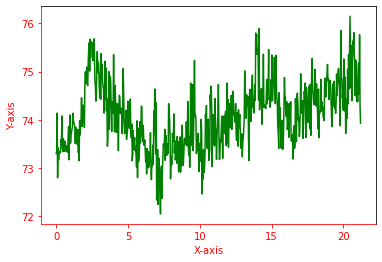

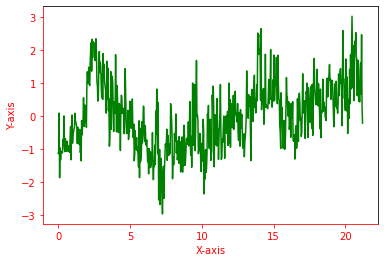

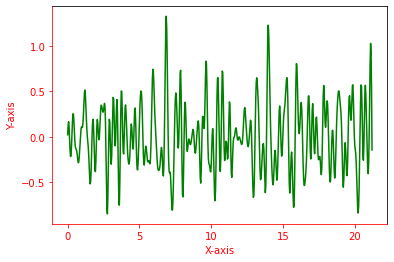

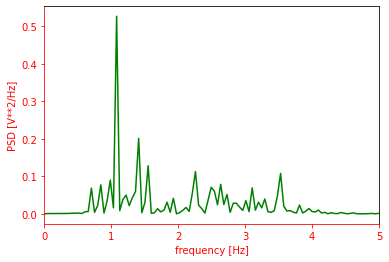

[2021-04-24 17:58:04,561] [INFO] [find_hr_in_window] [49] : Heart rate of window 1: 1.0832025117739403


In [13]:
color_sig_array = np.asarray(color_sig)
red = color_sig_array[:,0]
green = color_sig_array[:,1]
blue = color_sig_array[:,2]

window_start = 0
window_size = 30
window_id = 0
limit = good_frame_number - int(round_fps) * window_size
while window_start < limit :
    find_hr_in_window(green, window_start, round_fps, window_id, window_size)
    window_start += int(round_fps) * window_size
    window_id += 1
if window_start < good_frame_number:
    window_id += 1
    find_hr_in_window(green, window_start, round_fps, window_id, good_frame_number - window_start)

In [26]:
import pywt
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet as MCD
import numpy as np
from sklearn.preprocessing import StandardScaler
from skimage.restoration import denoise_wavelet
from matplotlib import pyplot as plt
import numpy as np
import scipy

def multivariate_Video_Signal(signal):
    """
    Algorithm 1
    :param signal: is a 2D signal. One dimension the signal from the forehead, and second is from above the upper lip
    :return: multivariate PPG!
    """
    H, J = 2, 4
    dwt_res = [(None, signal)]
    for i in range(0, J):
        approx_i, det_i = pywt.dwt(dwt_res[i][1], 'sym2')
        dwt_res.append((det_i, approx_i))
    first_details = np.asarray(dwt_res[1][0])
    noise_matrix = MCD(random_state=0).fit(first_details).covariance_
#     v, diagonal_mat, v_transpose = np.linalg.svd(
#         noise_matrix)
    diagonal_mat,v = scipy.linalg.schur(noise_matrix) # shur decomposition instead of svd decomposition
    v_t = v.T
    xi_hats = []
    xi_js = []
    for j in range(1, J + 1):
        xi_j = np.dot(dwt_res[1][0], v)
        xi_js.append(xi_j)
        for h in range(0, H):
            n = len(signal[0])
            val_h = np.sqrt(2 * diagonal_mat.diagonal() * np.log(n)) # TODO: where h index is counted
            xi_hat = pywt.threshold(data=xi_j[h], value=val_h)
            xi_hats.append(xi_hat)
    phi = None # TODO : should figure out what is that
    pca = PCA()
    phi_norm = StandardScaler().fit_transform(phi) # normalize 
    pca.fit(phi_norm)
    phi_hat = pca.transform(phi_norm)
    xi_hat = None # TODO : should figure out what is that
    multivariate_ppg = pywt.idwt(phi_hat, xi_hat, 'sym2')
    return multivariate_ppg

# data that i used to test the algorithm:
x = pywt.data.ecg().astype(float) / 256
y = pywt.data.ecg().astype(float) / 256
sigma = 0.05
x_noist = x + sigma * np.random.randn(x.size)
y_noisy = x + 2*sigma * np.random.randn(y.size)
combined = np.vstack((x_noist, y_noisy)) # making 2d array

multivariate_Video_Signal(combined)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
<ipython-input-26-f8c63b4dab91>:35: RuntimeWarning: invalid value encountered in sqrt
  val_h = np.sqrt(2 * diagonal_mat.diagonal() * np.log(n)) # TODO: where h index is counted


ValueError: Expected 2D array, got scalar array instead:
array=nan.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [25]:
# Peaks detection + write to csv the times

(637,)


ValueError: Input array has fewer dimensions than the specified axes

# Peaks detection + write to csv the times

In [ ]:
import pandas as pd
def indexes(y, thres=0.3, min_dist=1, thres_abs=False):
    if isinstance(y, np.ndarray) and np.issubdtype(y.dtype, np.unsignedinteger):
        raise ValueError("y must be signed")

    if not thres_abs:
        thres = thres * (np.max(y) - np.min(y)) + np.min(y)

    min_dist = int(min_dist)

    # compute first order difference
    dy = np.diff(y)

    # propagate left and right values successively to fill all plateau pixels (0-value)
    zeros, = np.where(dy == 0)

    # check if the signal is totally flat
    if len(zeros) == len(y) - 1:
        return np.array([])

    if len(zeros):
        # compute first order difference of zero indexes
        zeros_diff = np.diff(zeros)
        # check when zeros are not chained together
        zeros_diff_not_one, = np.add(np.where(zeros_diff != 1), 1)
        # make an array of the chained zero indexes
        zero_plateaus = np.split(zeros, zeros_diff_not_one)

        # fix if leftmost value in dy is zero
        if zero_plateaus[0][0] == 0:
            dy[zero_plateaus[0]] = dy[zero_plateaus[0][-1] + 1]
            zero_plateaus.pop(0)

        # fix if rightmost value of dy is zero
        if len(zero_plateaus) and zero_plateaus[-1][-1] == len(dy) - 1:
            dy[zero_plateaus[-1]] = dy[zero_plateaus[-1][0] - 1]
            zero_plateaus.pop(-1)

        # for each chain of zero indexes
        for plateau in zero_plateaus:
            median = np.median(plateau)
            # set leftmost values to leftmost non zero values
            dy[plateau[plateau < median]] = dy[plateau[0] - 1]
            # set rightmost and middle values to rightmost non zero values
            dy[plateau[plateau >= median]] = dy[plateau[-1] + 1]

    # find the peaks by using the first order difference
    peaks = np.where(
        (np.hstack([dy, 0.0]) < 0.0)
        & (np.hstack([0.0, dy]) > 0.0)
        & (np.greater(y, thres))
    )[0]

    # handle multiple peaks, respecting the minimum distance
    if peaks.size > 1 and min_dist > 1:
        highest = peaks[np.argsort(y[peaks])][::-1]
        rem = np.ones(y.size, dtype=bool)
        rem[peaks] = False

        for peak in highest:
            if not rem[peak]:
                sl = slice(max(0, peak - min_dist), peak + min_dist + 1)
                rem[sl] = True
                rem[peak] = False

        peaks = np.arange(y.size)[~rem]

    return peaks
green_buttered = filter_channel(green,round_fps)
peaks = indexes(green_buttered,min_dist=20)
x = np.arange(window_size,step=1/round_fps)
plt.plot(x,green_buttered,'-go',markerfacecolor='red',markevery=peaks)
plt.show()
print(x[peaks])
np.savetxt("time_of_peaks.csv", x[peaks], delimiter=",")

In [ ]:
# a = Pxx_den
# ind = np.argsort(a)
# max_ind = ind[-5:]
# print(f[max_ind])
# print("HR for this video is: " +str(f[max_ind].mean()))

In [ ]:
# if good_frame_number != greens.size: # TO BE REVIEW BY EYAL, POSSIBLE BUG FIX HERE!
#     frame_number = greens.size
# axis = np.arange((good_frame_number / round_fps), step=(1 / 30)) # axis is Time
# plot_result(greens, reds, blues, axis, "All 3 channels") # original signals
# # apply filtering on all the channels:
# green_buttered = filter_channel(greens,round_fps)
# red_buttered = filter_channel(reds,round_fps)
# blue_buttered = filter_channel(blues,round_fps)
# # plotting the channels after apllying the filter
# plot_result(green_buttered, red_buttered, blue_buttered, axis, "After Filter") # after filtering

In [ ]:
# if good_frame_number != greens.size: # TO BE REVIEW BY EYAL, POSSIBLE BUG FIX HERE!
#     frame_number = greens.size
# axis = np.arange((good_frame_number / round_fps), step=(1 / 30)) # axis is Time
# plot_result(greens, reds, blues, axis, "All 3 channels") # original signals
# # apply filtering on all the channels:
# green_buttered = filter_channel(greens,round_fps)
# red_buttered = filter_channel(reds,round_fps)
# blue_buttered = filter_channel(blues,round_fps)
# # plotting the channels after apllying the filter
# plot_result(green_buttered, red_buttered, blue_buttered, axis, "After Filter") # after filtering

### PSD estimation using 'Welch' or 'Periodogram'

In [ ]:
# f, Pxx_den = sig.welch(green_buttered, round_fps,'flattop', 1024, scaling='spectrum')

### Plot final results

In [ ]:
# plt.figure(f, Pxx_den)
# #plt.semilogy(f, Pxx_den)
# plt.ylim([1e-7, 1e2])
# plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD [V**2/Hz]')
# plt.show()
# # periodogram method:
# f, Pxx_den = sig.periodogram(green_buttered, round_fps)
# plt.semilogy(f, Pxx_den)
# plt.ylim([1e-7, 1e2])
# plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD [V**2/Hz]')
# plt.show()

